# Probabilistic Methods

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

**load data**

In [2]:
url = env.get_db_access("logs")

df = pd.read_sql('SELECT * FROM api_access', url)
df

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...
...,...
13969,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13970,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13971,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...
13972,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...


**Learn data**

In [3]:

# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [4]:
df = df.entry.apply(parse_log_entry) # Applying the function to the entire dataframe
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


**Add some anomalies**

In [5]:

# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df, new], ignore_index=True)

In [6]:
df.shape

(13978, 8)

**fix index**

In [7]:
df['size_mb'] = df['size'] / 1024 / 1024 # adding a new column scaled to megabytes for ease of understanding
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [8]:
df.size_mb.sort_values()

timestamp
2019-04-16 20:45:17    0.000000
2019-04-16 21:02:07    0.000000
2019-04-16 20:33:24    0.000000
2019-04-16 22:21:38    0.000000
2019-04-16 21:30:46    0.000000
                         ...   
2019-04-16 21:13:58    0.489937
2019-04-16 20:09:14    0.489937
2019-04-16 20:58:31    0.489937
2019-04-21 10:02:41    1.099591
2019-04-19 19:42:41    1.961066
Name: size_mb, Length: 13978, dtype: float64

## Detect anomalies

In [15]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False), columns=["count"]).reset_index()
ip_df.head()

,index,count


In [26]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip_', "ip":"count"})

# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame(df.ip.value_counts(normalize=True, dropna=False)).\
reset_index().rename(columns={'index':'ip_', "ip":"proportion"})

# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2, on='ip_')
ip_df.head()


,ip_,count,proportion
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


<Axes: xlabel='ip_', ylabel='count'>

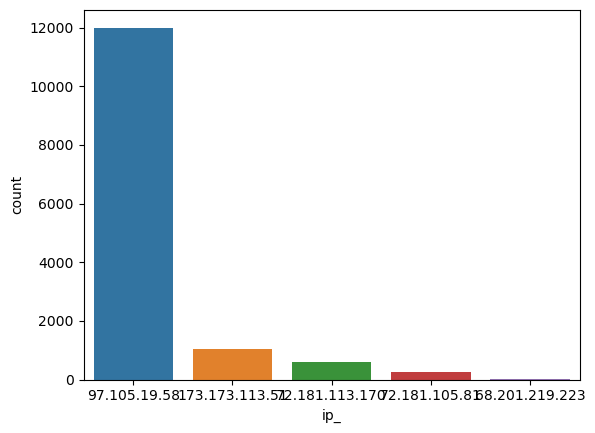

In [29]:
sns.barplot(data=ip_df.head(), x="ip_", y="count")

## Conditional Probabilities - Intersectionality

In [34]:
# group by ip address and status code
df.groupby(['ip', 'status_code']).size()


ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
95.31.16.121    301                1
95.31.18.119    200                1
97.105.15.120   301                1
97.105.19.58    200            11985
                499               14
dtype: int64

In [36]:
# look at the propotions of the goup
p_a_and_b = df.groupby(['ip', 'status_code']).size()/len(df)
p_a_and_b

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [38]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


- Cases where the probability is < 100%
- Status codes other than 200

In [39]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167
